In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

ModuleNotFoundError: No module named 'torchvision'

In [2]:
#import libraries
import sklearn
import shap

In [15]:
# Linear regression
X,y=shap.datasets.california(n_points=100)


In [4]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43
...,...,...,...,...,...,...,...,...
1640,5.2699,8.0,7.386811,1.071850,3325.0,3.272638,37.98,-121.84
17326,4.2222,18.0,6.436314,1.162602,1048.0,2.840108,34.64,-120.08
4191,5.2049,37.0,5.090196,0.949020,750.0,2.941176,34.12,-118.22
20078,2.6094,20.0,6.802632,1.355263,647.0,2.837719,38.03,-120.39


In [5]:
y

array([1.369  , 2.413  , 2.007  , 0.725  , 4.6    , 1.2    , 2.47   ,
       3.369  , 3.397  , 2.656  , 2.379  , 0.922  , 0.795  , 1.375  ,
       2.201  , 2.761  , 3.953  , 3.     , 1.827  , 3.864  , 1.314  ,
       0.742  , 2.31   , 3.941  , 1.761  , 1.734  , 2.021  , 1.708  ,
       0.926  , 0.57   , 4.657  , 3.726  , 4.     , 1.539  , 1.     ,
       1.587  , 1.421  , 1.396  , 3.197  , 1.313  , 1.107  , 0.849  ,
       0.704  , 2.76   , 1.58   , 0.542  , 1.232  , 1.162  , 1.592  ,
       2.155  , 2.781  , 0.66   , 2.929  , 1.712  , 2.75   , 0.962  ,
       5.00001, 1.676  , 1.829  , 2.231  , 1.733  , 1.891  , 1.177  ,
       2.468  , 0.618  , 0.934  , 0.557  , 3.905  , 2.03   , 0.889  ,
       5.00001, 1.703  , 1.55   , 0.579  , 5.00001, 1.083  , 3.506  ,
       2.032  , 2.214  , 1.553  , 2.706  , 2.     , 0.875  , 2.045  ,
       1.969  , 1.839  , 0.786  , 1.458  , 0.767  , 0.985  , 2.217  ,
       1.713  , 0.618  , 2.747  , 0.75   , 2.042  , 3.75   , 2.408  ,
       1.391  , 3.90

In [6]:
xdata=shap.utils.sample(X,50)

In [7]:
model=sklearn.linear_model.LinearRegression()
model.fit(X,y)

LinearRegression()

In [8]:
#examining the model coefficients

In [9]:
for i in range(X.shape[1]):
  print(X.columns[i],"=",model.coef_[i].round(5))

MedInc = 0.52995
HouseAge = 0.001
AveRooms = -0.25758
AveBedrms = 1.3156
Population = 0.00012
AveOccup = -0.37497
Latitude = -0.51609
Longitude = -0.48583


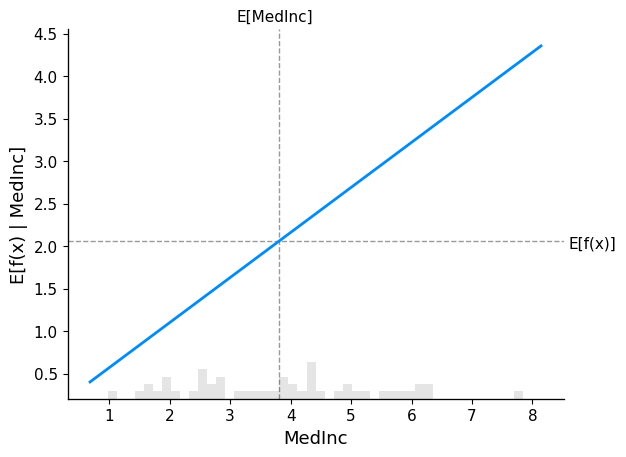

In [11]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    xdata,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [16]:
# DeepExplainer MNIST example

In [17]:
batch_size = 128
num_epochs = 2
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303554
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.211646
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.224697
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.872646
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.651665

Test set: Average loss: 0.0043, Accuracy: 9091/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.632791
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.557363
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.539060
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.536523
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.427913

Test set: Average loss: 0.0024, Accuracy: 9418/10000 (94%)



In [18]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [19]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

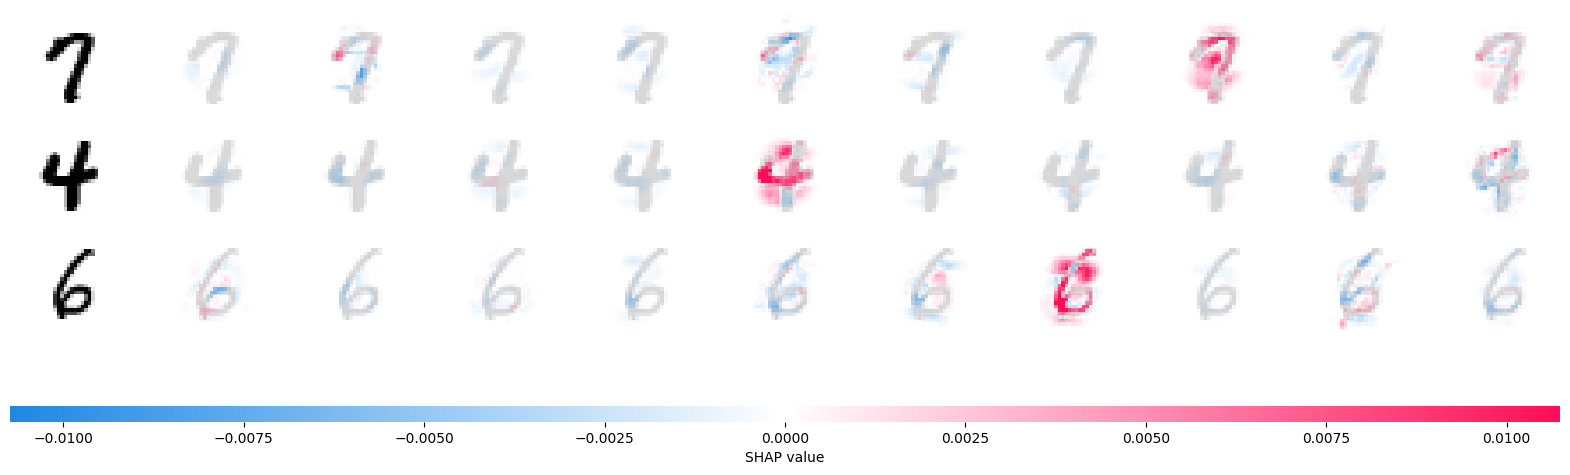

In [20]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)